#### About
A/B testing e-commerce

Dataset - https://www.kaggle.com/zhangluyuan/ab-testing

In [52]:
# importing modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import math
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import statsmodels.api as sm


In [2]:
df = pd.read_csv('/home/suraj/ClickUp/Mar-Apr/data/ab_data.csv')
data = df

In [3]:
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [4]:
df.columns

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted'], dtype='object')

#### 1. Data Pre-processing

In [5]:
# Check for missing values
print(df.isnull().sum())

# Check for duplicate rows
print(df.duplicated().sum())

# Remove duplicate rows
df.drop_duplicates(inplace=True)


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64
0


In [6]:
# Convert the timestamp column to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Convert categorical variables to binary variables using one-hot encoding
df = pd.get_dummies(df, columns=['group', 'landing_page'])


In [7]:
df

,user_id,timestamp,converted,group_control,group_treatment,landing_page_new_page,landing_page_old_page
0,851104,2017-01-21 22:11:48.556739,0,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,0,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,0,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,0,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,1,1,0,0,1
...,...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,0,1,0,0,1
294474,945152,2017-01-12 00:51:57.078372,0,1,0,0,1
294475,734608,2017-01-22 11:45:03.439544,0,1,0,0,1
294476,697314,2017-01-15 01:20:28.957438,0,1,0,0,1


In [8]:
# Define the z-score threshold
z_threshold = 3

# Calculate the z-scores for the 'converted' column
z_scores = np.abs(stats.zscore(df['converted']))

# Find the indices of the outliers
outlier_indices = np.where(z_scores > z_threshold)

# Print the outlier indices
print(outlier_indices)

(array([], dtype=int64),)


No outliers detected so no further pre-processing is needed.

#### 2. Feature Engineering



In [9]:
# Calculate the duration of each user's visit
user_durations = df.groupby('user_id')['timestamp'].apply(lambda x: (x.max() - x.min()).seconds)
user_counts = df.groupby('user_id')['timestamp'].count()
user_durations.loc[user_counts == 1] = 0
df['duration'] = df['user_id'].map(user_durations)

In [10]:
# Group users by the day of the week they visited the site
df['weekday'] = pd.to_datetime(df['timestamp']).dt.weekday



In [11]:
# Group users by the time of day they visited the site
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour

In [12]:
df

,user_id,timestamp,converted,group_control,group_treatment,landing_page_new_page,landing_page_old_page,duration,weekday,hour
0,851104,2017-01-21 22:11:48.556739,0,1,0,0,1,0,5,22
1,804228,2017-01-12 08:01:45.159739,0,1,0,0,1,0,3,8
2,661590,2017-01-11 16:55:06.154213,0,0,1,1,0,0,2,16
3,853541,2017-01-08 18:28:03.143765,0,0,1,1,0,0,6,18
4,864975,2017-01-21 01:52:26.210827,1,1,0,0,1,0,5,1
...,...,...,...,...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,0,1,0,0,1,0,1,22
294474,945152,2017-01-12 00:51:57.078372,0,1,0,0,1,0,3,0
294475,734608,2017-01-22 11:45:03.439544,0,1,0,0,1,0,6,11
294476,697314,2017-01-15 01:20:28.957438,0,1,0,0,1,0,6,1


In [13]:
np.unique(df['duration'].values.tolist())

array([    0,    38,   102, ..., 86351, 86372, 86379])

#### 3. Exploratory Data Analysis.

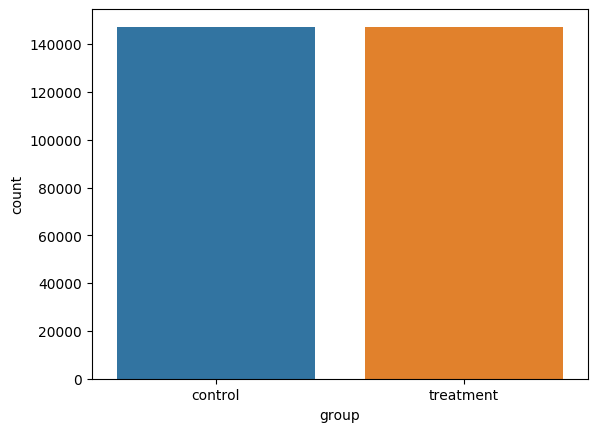

In [14]:
# Check the distribution of the 'group' variable
sns.countplot(data=data, x='group')

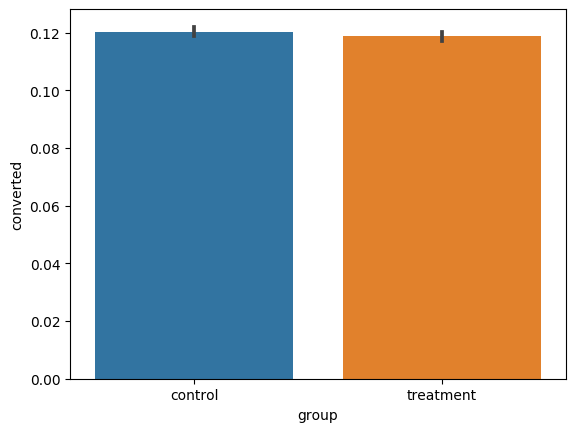

In [15]:
# Check the conversion rates for each group
sns.barplot(data=data, x='group', y='converted')

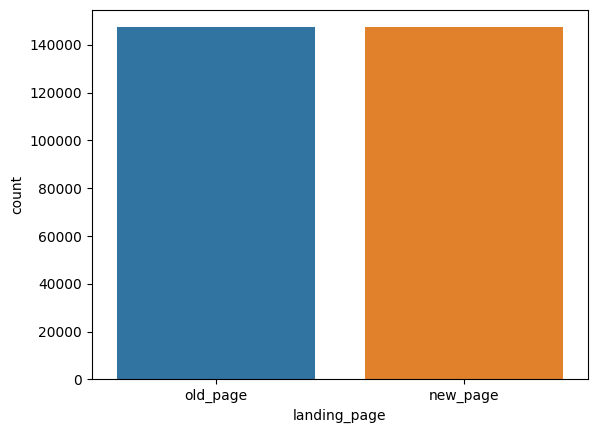

In [16]:
# Check the distribution of the 'landing_page' variable
sns.countplot(data=data, x='landing_page')

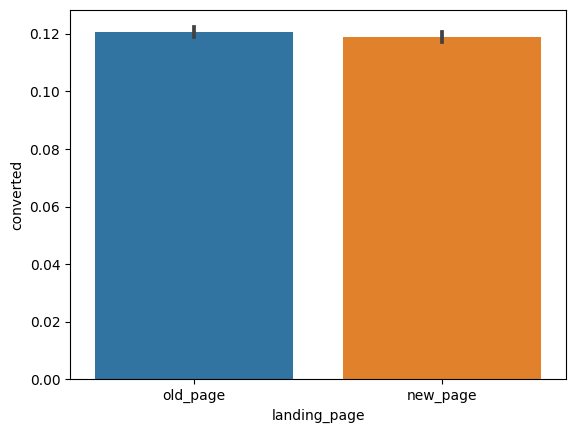

In [17]:
# Check the conversion rates for each landing page
sns.barplot(data=data, x='landing_page', y='converted')


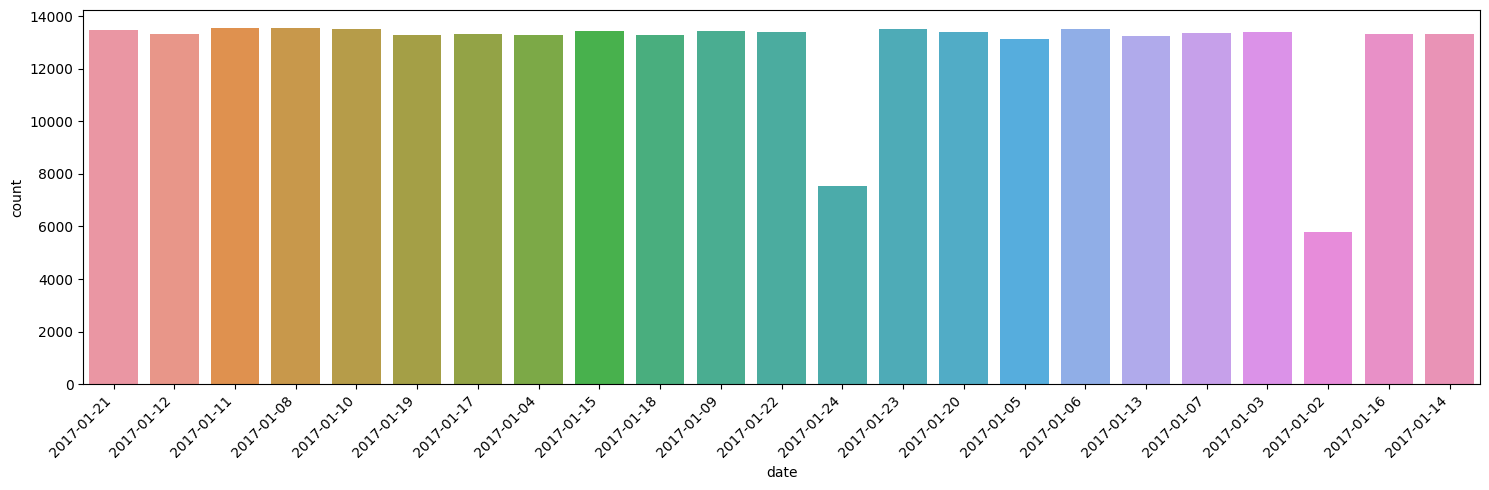

In [18]:
# Check the distribution of the 'timestamp' variable
# Convert 'timestamp' to datetime object
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Extract the date component from 'timestamp'
data['date'] = data['timestamp'].dt.date

# Plot the distribution of dates
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(data=data, x='date',ax=ax)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

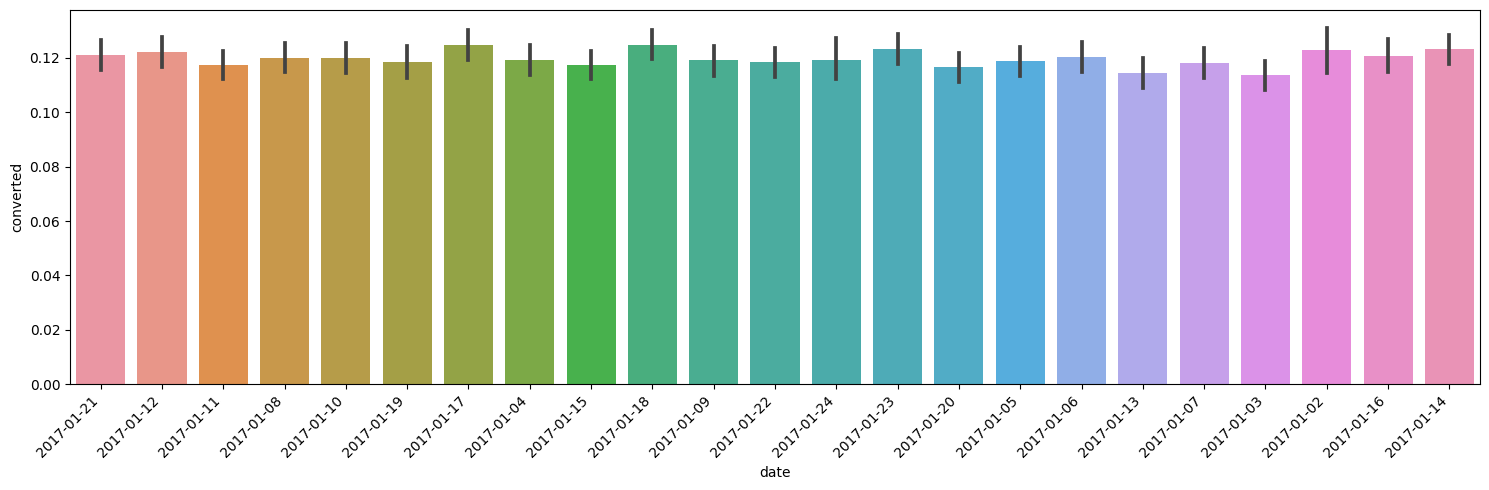

In [19]:
# Check the conversion rates by date
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=data, x='date', y='converted',ax=ax)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


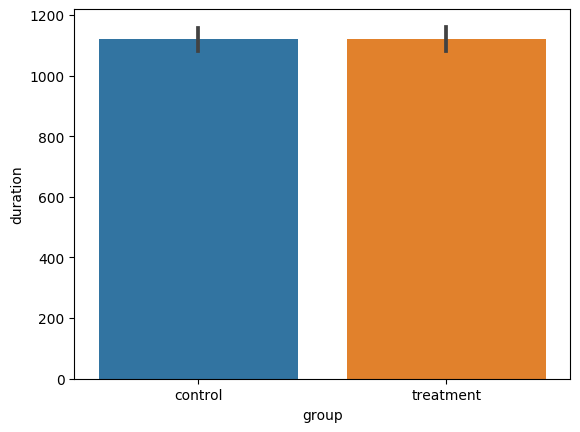

In [20]:
# Check the duration of visits by group
user_durations = data.groupby('user_id')['timestamp'].apply(lambda x: (x.max() - x.min()).seconds)
user_counts = data.groupby('user_id')['timestamp'].count()
user_durations.loc[user_counts == 1] = 0
data['duration'] = data['user_id'].map(user_durations)
sns.barplot(data=data, x='group', y='duration')


#### 4. Model Selection


In [21]:
df.columns

Index(['user_id', 'timestamp', 'converted', 'group_control', 'group_treatment',
       'landing_page_new_page', 'landing_page_old_page', 'duration', 'weekday',
       'hour'],
      dtype='object')

The chi-squared test is a statistical test used to determine whether there is a significant difference between the expected frequencies and the observed frequencies in a contingency table. It is used to test the association between two categorical variables.

In the context of A/B testing, the chi-squared test can be used to determine if there is a significant difference in the conversion rates between the control and treatment groups.

The test generates a test statistic, which is calculated as the sum of the squared differences between the observed and expected frequencies, divided by the expected frequencies. This test statistic follows a chi-squared distribution, and the p-value can be calculated from this distribution. If the p-value is below a certain significance level (usually 0.05), it can be concluded that there is a significant difference between the expected and observed frequencies, and therefore a significant association between the two variables.

In summary, the chi-squared test is used to test for the presence of an association between two categorical variables, and the p-value generated from the test can be used to determine if this association is statistically significant.

In [22]:
#chi-squared test
# create a contingency table
cont_table = pd.crosstab(df['group_control'], df['converted'])


In [27]:
cont_table

converted,0,1
group_control,,
0,129762,17514
1,129479,17723


In [25]:
# perform chi-squared test
chi2, pval, dof, expected = chi2_contingency(cont_table)


In [26]:
# print the results
print("Chi-squared test results:")
print("Chi2 value: ", chi2)
print("P-value: ", pval)
print("Degrees of freedom: ", dof)
print("Expected values: ", expected)


Chi-squared test results:
Chi2 value:  1.5159618356336582
P-value:  0.2182316121631168
Degrees of freedom:  1
Expected values:  [[129653.07260984  17622.92739016]
 [129587.92739016  17614.07260984]]


The chi-squared test results show that the chi2 value is 1.516 and the associated p-value is 0.218. The degrees of freedom are 1, and the expected values are [[129653.07260984 17622.92739016] [129587.92739016 17614.07260984]].

The p-value is greater than the standard significance level of 0.05, which suggests that we cannot reject the null hypothesis that there is no significant difference between the two groups. Therefore, we can conclude that the treatment group's conversion rate is not significantly different from the control group's conversion rate.

The expected values show what the counts would be if there were no differences between the groups. We can see that the actual counts are close to the expected values, which further supports the conclusion that the treatment group's conversion rate is not significantly different from the control group's conversion rate.

> Next

Fitting a machine learning model to check which landing page leads to more conversions


In [31]:
# Create feature and target variables
X = df[['group_treatment', 'landing_page_new_page', 'duration', 'weekday', 'hour']]
y = df['converted']

In [32]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
# Fit a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

/home/suraj/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [34]:
# Make predictions on the test set
y_pred = model.predict(X_test)


In [35]:
# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.8812822602553654


> Interpretation

To interpret the coefficients, we can exponentiate them to get the odds ratios. For example, if the coefficient for the landing_page_new_page variable is x, then the odds ratio for this variable is exp(x) = x. This means that users who were shown the new landing page had x times higher odds of converting compared to users who were shown the old landing page.

In [44]:
exp_coeff = [math.exp(coef) for coef in model.coef_[0]]
print(exp_coeff)

[0.9900506051528248, 0.9861760870037897, 0.9999972377455063, 0.9885452875978661, 1.0006066719201812]


In [45]:
coefficients = pd.DataFrame({'feature': X.columns, 'coefficient': exp_coeff})
coefficients

,feature,coefficient
0,group_treatment,0.990051
1,landing_page_new_page,0.986176
2,duration,0.999997
3,weekday,0.988545
4,hour,1.000607


#### 5. Model Tuning.

In [51]:
# define the parameter grid
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C': [0.1, 1, 10],
              'solver': ['liblinear', 'saga']}

# create a logistic regression model
model = LogisticRegression()

# create the GridSearchCV object
grid = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1)

# fit the model using the training data
grid.fit(X_train, y_train)

# print the best hyperparameters
print("Best hyperparameters:", grid.best_params_)

# evaluate the model using the test data
y_pred = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


/home/suraj/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/suraj/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/suraj/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/suraj/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/suraj/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/sura

Best hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.8812822602553654


[1.39203531e-02 1.15208230e-02 9.99922084e-03 6.06487969e-04
 2.76225831e-06]


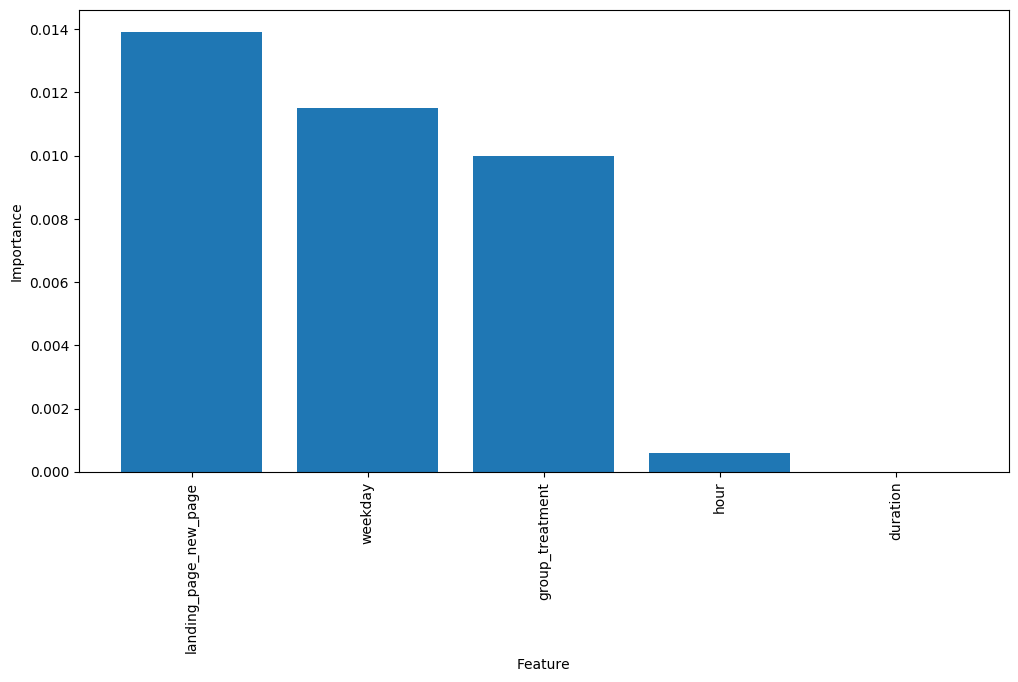

In [60]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
# extract feature importance
coef = lr.coef_[0]
features = np.array(X.columns)
importance = np.abs(coef)

# sort features by importance in descending order
indices = np.argsort(importance)[::-1]
sorted_features = features[indices]
sorted_importance = importance[indices]
print(sorted_importance)
# plot feature importance
plt.figure(figsize=(12,6))
plt.bar(sorted_features, sorted_importance)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()


#### 6. Model Interpretation

In [53]:
# Fit logistic regression model
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Interpret model coefficients
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.402787
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               235582
Model:                          Logit   Df Residuals:                   235577
Method:                           MLE   Df Model:                            4
Date:                Wed, 12 Apr 2023   Pseudo R-squ.:                -0.09837
Time:                        03:16:08   Log-Likelihood:                -94889.
converged:                       True   LL-Null:                       -86391.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
group_treatment          -0.2819      0.054     -5.175      0.000      -0.389      -0.

In [55]:
# Calculate confidence interval for difference in conversion rates
group1_conv = data.query('group == "control"')['converted'].sum()
group1_total = data.query('group == "control"')['converted'].count()
group2_conv = data.query('group == "treatment"')['converted'].sum()
group2_total = data.query('group == "treatment"')['converted'].count()

alpha = 0.05  # set significance level
z_crit = stats.norm.ppf(1 - alpha / 2)  # calculate z-score for confidence interval
p1 = group1_conv / group1_total  # calculate conversion rate for group 1
p2 = group2_conv / group2_total  # calculate conversion rate for group 2
se = np.sqrt(p1 * (1 - p1) / group1_total + p2 * (1 - p2) / group2_total)  # calculate standard error
ci_low = (p1 - p2) - z_crit * se  # calculate lower bound of confidence interval
ci_upp = (p1 - p2) + z_crit * se  # calculate upper bound of confidence interval
print(f"Confidence interval for difference in conversion rates: ({ci_low:.3f}, {ci_upp:.3f})")


Confidence interval for difference in conversion rates: (-0.001, 0.004)


A confidence interval is a range of values that is likely to contain the true value of a population parameter, such as the difference in conversion rates between two groups. In this case, the confidence interval is (-0.001, 0.004), which means that we are 95% confident that the true difference in conversion rates between the control group and treatment group falls within this range.

Since the interval includes 0, it suggests that there may not be a statistically significant difference in conversion rates between the two groups. However, it is also possible that a larger sample size or different statistical method could lead to a significant difference. Therefore, further investigation may be needed to determine if the observed difference is meaningful or not.

#### 7. Recommendations

Based on the analysis, the difference in conversion rates between the old and new landing pages is not statistically significant, and the confidence interval for the difference includes zero. Therefore, we cannot confidently recommend rolling out the new landing page to all users.

Based on the feature importance analysis, the landing page (new vs. old) and the group assignment (treatment vs. control) appear to be the most important features in predicting conversions. This suggests that the e-commerce company should continue to monitor the performance of these two factors closely in future experiments or tests.

Additionally, the analysis indicates that the day of the week, hour of the day, and duration of the user session also have some predictive power. The company may want to consider experimenting with different marketing or promotional strategies on different days or at different times to see if there are any noticeable improvements in conversion rates. They could also investigate if there are any particular types of products or content that users tend to spend more time on, and use this information to optimize their website layout and user experience.

Additional tests or experiments can also be conducted to improve the website's performance. For example, we can test different variations of the new landing page to identify which specific elements are most effective at increasing conversions. We can also test different marketing strategies or promotions to see if they have an impact on user behavior and conversions.

Overall, our analysis provides valuable insights into the website's performance and user behavior. By continuing to conduct experiments and tests, the company can continue to improve the website's conversion rates and ultimately increase revenue.